# Generative Adversarial Networks

## Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import time
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'

## Constants

In [2]:
DATA_DIR = "/home/SharedData/intern_sayan/GAN/MNIST"

CHECKPOINT_DIR = "/home/SharedData/intern_sayan/GAN/"
CHECKPOINT_G = "mnist_gan_gen.pth"
CHECKPOINT_D = "mnist_gan_dis.pth"

SHOULD_CHECKPOINT = True
LOAD_CHECKPOINT = False

!mkdir -p images

CUDA = 1
BATCH_SIZE = 256
EPOCHS = 200

img_shape = (1, 28, 28)
lr_g = 1e-3
lr_d = 1e-5
latent_dim = 100

## Data

# train batches: 235, # test batches: 40
train image: torch.Size([1, 28, 28])
test image: torch.Size([1, 28, 28])


Text(0.5,1,'Test')

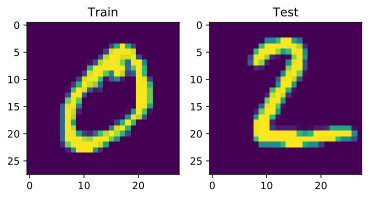

In [3]:
# Train Dataloader
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

# Test Dataloader
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(DATA_DIR, train=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

print(f"# train batches: {len(train_loader)}, # test batches: {len(test_loader)}")

print(f"train image: {train_loader.dataset[0][0].size()}")
print(f"test image: {test_loader.dataset[0][0].size()}")

fig = plt.figure()

a = fig.add_subplot(1,2,1)
plt.imshow(train_loader.dataset[1][0].reshape(28,28))
a.set_title("Train")

a = fig.add_subplot(1,2,2)
plt.imshow(test_loader.dataset[1][0].reshape(28,28))
a.set_title("Test")

## Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), *img_shape)
        
        return img

## Discriminator

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        p_value = self.model(img_flat)

        return p_value

## Training

In [ ]:
# Loss function
adversarial_loss = torch.nn.BCELoss()

# Generator & Discriminator
generator = Generator(latent_dim=latent_dim)
discriminator = Discriminator()

if CUDA:
    adversarial_loss.cuda(CUDA)
    generator.cuda(CUDA)
    discriminator.cuda(CUDA)
    
if LOAD_CHECKPOINT:
    generator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                      CHECKPOINT_G)))
    discriminator.load_state_dict(torch.load(os.path.join(CHECKPOINT_DIR,
                                                          CHECKPOINT_G)))
    
# Optimizers
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr_g)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr_d)

In [ ]:
losses = {"generator" : list(), "discriminator": list()}

for epoch in range(EPOCHS):
    epoch_g_loss, epoch_d_loss = 0,0
    delta = time.time()
    
    for batch_idx, (imgs, _label) in enumerate(train_loader):
        if CUDA:
            # Adversarial ground truths
            valid = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                              1).fill_(1.0).cuda(CUDA),
                                            requires_grad=False)
            fake = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                             1).fill_(0.0).cuda(CUDA),
                                           requires_grad=False)

            # Real data
            real_imgs = torch.autograd.Variable(imgs.type(torch.Tensor)).cuda(CUDA)
            
            # Sampled noise
            z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,
                                                                           1,
                                                                           (imgs.shape[0],
                                                                            latent_dim))).cuda(CUDA))
        else:
            # Adversarial ground truths
            valid = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                              1).fill_(1.0),
                                            requires_grad=False)
            fake = torch.autograd.Variable(torch.FloatTensor(imgs.size(0),
                                                             1).fill_(0.0),
                                           requires_grad=False)

            # Real data
            real_imgs = torch.autograd.Variable(imgs.type(torch.Tensor))
            
            # Sampled noise
            z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,
                                                                           1,
                                                                           (imgs.shape[0],
                                                                            latent_dim))))
        
        
        # Generator Training
        optimizer_G.zero_grad()
            
        gen_imgs = generator(z)
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)

        g_loss.backward()
        optimizer_G.step()
        
        # Discriminator Training
        optimizer_D.zero_grad()
        
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()
        
        epoch_g_loss += g_loss.float()
        epoch_d_loss += d_loss.float()
        
        batches_done = epoch * len(train_loader) + batch_idx
        
        if batches_done % 400 == 0:
            save_image(gen_imgs.data[:256], 'images/%d.png' % batches_done, nrow=16, normalize=True)
        
    delta = time.time() - delta
    
    losses["generator"].append(epoch_g_loss)
    losses["discriminator"].append(epoch_d_loss)
    
    if SHOULD_CHECKPOINT:
        torch.save(generator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                        CHECKPOINT_G))
        torch.save(discriminator.state_dict(), os.path.join(CHECKPOINT_DIR,
                                                            CHECKPOINT_D))
    
    print(f"{delta:.2f} secs [Epoch {(epoch+1):3}/{EPOCHS}] [D loss: {epoch_d_loss:.8f}] [G loss: {epoch_g_loss:.8f}]")
        

14.12 secs [Epoch   1/200] [D loss: 192.65811157] [G loss: 99.69221497]
13.98 secs [Epoch   2/200] [D loss: 180.86265564] [G loss: 105.90847778]
13.62 secs [Epoch   3/200] [D loss: 177.59890747] [G loss: 113.71669006]
13.39 secs [Epoch   4/200] [D loss: 176.93545532] [G loss: 119.27762604]
13.81 secs [Epoch   5/200] [D loss: 173.85067749] [G loss: 127.18733978]
13.76 secs [Epoch   6/200] [D loss: 171.86093140] [G loss: 127.85354614]
13.45 secs [Epoch   7/200] [D loss: 169.11181641] [G loss: 137.48342896]
13.34 secs [Epoch   8/200] [D loss: 165.75325012] [G loss: 138.73342896]
13.97 secs [Epoch   9/200] [D loss: 165.62023926] [G loss: 146.51660156]
13.46 secs [Epoch  10/200] [D loss: 168.34497070] [G loss: 140.71540833]
13.42 secs [Epoch  11/200] [D loss: 165.08691406] [G loss: 144.90898132]
13.63 secs [Epoch  12/200] [D loss: 162.67532349] [G loss: 149.46780396]
13.92 secs [Epoch  13/200] [D loss: 160.49732971] [G loss: 151.02273560]
13.47 secs [Epoch  14/200] [D loss: 161.52659607] [G

13.31 secs [Epoch 114/200] [D loss: 85.30320740] [G loss: 278.97729492]
13.54 secs [Epoch 115/200] [D loss: 83.56266022] [G loss: 279.16604614]
13.45 secs [Epoch 116/200] [D loss: 84.43070984] [G loss: 275.91305542]
13.70 secs [Epoch 117/200] [D loss: 72.86363983] [G loss: 319.45471191]
13.68 secs [Epoch 118/200] [D loss: 58.34917068] [G loss: 370.63952637]
13.52 secs [Epoch 119/200] [D loss: 82.50559998] [G loss: 287.79244995]
13.46 secs [Epoch 120/200] [D loss: 72.62376404] [G loss: 328.01992798]
14.05 secs [Epoch 121/200] [D loss: 69.42794800] [G loss: 334.53991699]
13.37 secs [Epoch 122/200] [D loss: 64.25881195] [G loss: 339.06008911]
13.49 secs [Epoch 123/200] [D loss: 74.07964325] [G loss: 315.39840698]
13.49 secs [Epoch 124/200] [D loss: 69.09551239] [G loss: 340.15524292]
13.47 secs [Epoch 125/200] [D loss: 51.59652328] [G loss: 393.49359131]
13.51 secs [Epoch 126/200] [D loss: 65.26004028] [G loss: 364.01809692]
13.35 secs [Epoch 127/200] [D loss: 69.20999908] [G loss: 334.12

## Visualisation

In [ ]:
plt.plot(range(len(losses["discriminator"])), losses["discriminator"])
plt.plot(range(len(losses["generator"])), losses["generator"])

plt.legend(['d_loss', 'g_loss'], loc='upper left')

In [ ]:
plt.plot(range(len(losses["discriminator"])), losses["discriminator"])

In [ ]:
plt.plot(range(len(losses["generator"])), losses["generator"])

In [ ]:
# Random sampling for inference
rows, cols = 4, 5
num_samples = rows * cols

if CUDA:
    z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,1, (num_samples, latent_dim))).cuda(CUDA))
else:
    z = torch.autograd.Variable(torch.FloatTensor(np.random.normal(0,1, (num_samples, latent_dim))))

image = generator(z).detach().cpu().numpy()

fig = plt.figure()

for row in range(rows):
    for col in range(cols):
        a = fig.add_subplot(rows, cols, row*cols + col + 1)
        plt.imshow(image[1].reshape(28, 28))